In [1]:
# %%
from utils import *
from crosscoder import CrossCoder
torch.set_grad_enabled(False);

In [2]:
# Pythia19m 30vs60 checkpoint crosscoder
repo_id: str = "victiny1223/crosscoder-checkpoints"
path: str = "blocks.3.hook_resid_pre"

In [3]:
# %%
cross_coder = CrossCoder.load_from_hf(repo_id = repo_id, path = path)

/home/ubuntu/crosscoders/crosscoder-model-diff-replication/crosscoder.py:201: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [11]:
# %%
norms = cross_coder.W_dec.norm(dim=-1)
norms.shape
# %%

torch.Size([16384, 2])

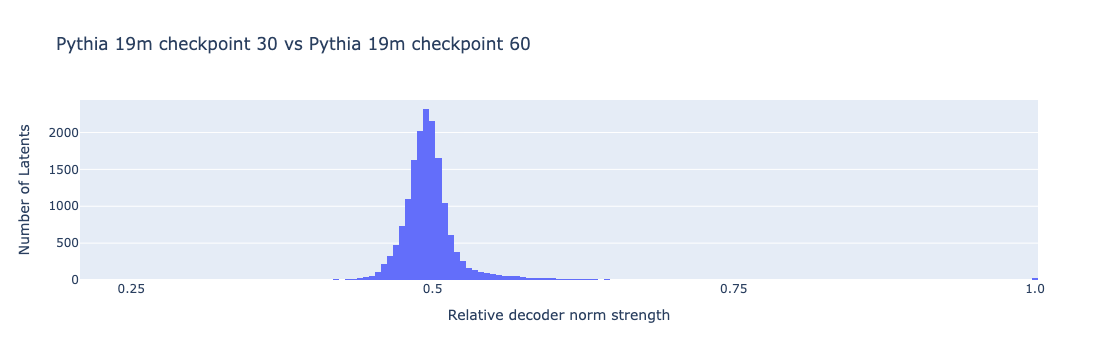

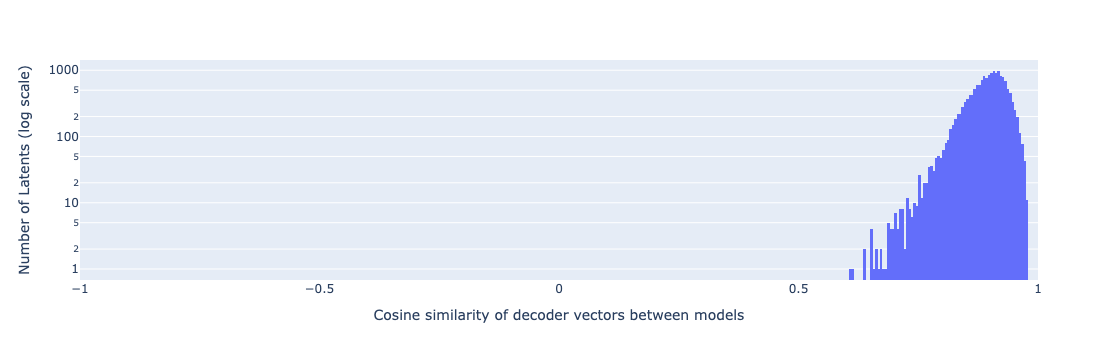

In [12]:
relative_norms = norms[:, 1] / norms.sum(dim=-1)
relative_norms.shape
# %%

fig = px.histogram(
    relative_norms.detach().cpu().numpy(), 
    title="Pythia 19m checkpoint 30 vs Pythia 19m checkpoint 60",
    labels={"value": "Relative decoder norm strength"},
    nbins=200,
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents")

# Update x-axis ticks
fig.update_xaxes(
    tickvals=[0, 0.25, 0.5, 0.75, 1.0],
    ticktext=['0', '0.25', '0.5', '0.75', '1.0']
)

# Display in notebook
fig.show()

# %%
shared_latent_mask = (relative_norms < 0.7) & (relative_norms > 0.3)
shared_latent_mask.shape
# %%
# Cosine similarity of recoder vectors between models

cosine_sims = (cross_coder.W_dec[:, 0, :] * cross_coder.W_dec[:, 1, :]).sum(dim=-1) / (cross_coder.W_dec[:, 0, :].norm(dim=-1) * cross_coder.W_dec[:, 1, :].norm(dim=-1))
cosine_sims.shape
# %%

fig = px.histogram(
    cosine_sims[shared_latent_mask].to(torch.float32).detach().cpu().numpy(), 
    log_y=True,  # Sets the y-axis to log scale
    range_x=[-1, 1],  # Sets the x-axis range from -1 to 1
    nbins=100,  # Adjust this value to change the number of bins
    labels={"value": "Cosine similarity of decoder vectors between models"}
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents (log scale)")

# Display in notebook
fig.show()

# %%

In [6]:
mask = relative_norms < 0.01
mask.shape

torch.Size([16384])

In [7]:
indices_0 = mask.nonzero().squeeze()
indices_0

tensor([], device='cuda:0', dtype=torch.int64)

# Analyse the unique latents

## Maximum activating examples
Get tokens that maximally activate latent_idx
- Run a bunch of tokens, collect activations and probably cache these
- Run activations through encode in batches

In [4]:
def get_max_activating_tokens(cross_coder, model_A, model_B, tokens, latent_idx, top_k=10):
    """
    tokens: input tokens to analyze [batch, seq_len]
    latent_idx: which latent dimension to analyze
    """
    with torch.no_grad():
        # Get activations from both models
        _, cache_A = model_A.run_with_cache(tokens, names_filter="blocks.3.hook_resid_pre")
        _, cache_B = model_B.run_with_cache(tokens, names_filter="blocks.3.hook_resid_pre")
        
        # Stack activations [2, batch, seq_len, d_model]
        acts = torch.stack([
            cache_A["blocks.3.hook_resid_pre"], 
            cache_B["blocks.3.hook_resid_pre"]
        ], dim=0)

        print(acts.shape)
        
        # Reshape to [batch*seq_len, 2, d_model]
        acts = einops.rearrange(acts, 
            "n_models batch seq_len d_model -> (batch seq_len) n_models d_model")
        
        # Get encoded activations
        encoded = cross_coder.encode(acts)  # [(batch*seq_len), d_hidden]
        
        # Get activations for specific latent
        latent_acts = encoded[:, latent_idx]
        
        # Find top activating positions
        top_values, top_indices = latent_acts.topk(top_k)
        
        # Map top_indices back to batch and sequence indices
        batch_size, seq_len = tokens.shape
        token_indices = top_indices % (batch_size * seq_len)
        batch_indices = token_indices // seq_len
        seq_indices = token_indices % seq_len
        
        return batch_indices, seq_indices, top_values

In [5]:
device = 'cuda:0'

In [10]:
import os

# Set the environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Verify that it's set
print(f"CUDA_LAUNCH_BLOCKING is set to: {os.environ['CUDA_LAUNCH_BLOCKING']}")

CUDA_LAUNCH_BLOCKING is set to: 1


In [6]:
from utils import load_pile_deduped_pythia_random_sampled
all_tokens = load_pile_deduped_pythia_random_sampled()[:30000, :]

Loading data from disk


/home/ubuntu/crosscoders/crosscoder-model-diff-replication/utils.py:184: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [11]:
print(all_tokens.dtype)

torch.int64


In [12]:
all_tokens.shape

torch.Size([30000, 64])

In [7]:
device = 'cuda:0'

N_1 = 30
pythia1 = HookedTransformer.from_pretrained("pythia-1.3b", checkpoint_index=N_1, device = device)


The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


Loaded pretrained model pythia-1.3b into HookedTransformer


In [14]:
N_2 = 90
pythia2 = HookedTransformer.from_pretrained("pythia-1.3b", checkpoint_index=N_2, device = device) # commented out due to too much memory

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model pythia-1.3b into HookedTransformer


In [15]:
pythia2 = None

In [14]:
all_tokens[:1000].shape

torch.Size([1000, 64])

In [8]:
def analyse_max_act_tok(latent_idx):
    print("-" * 50)
    print("LatentIDX:", latent_idx)
    batch_indices, seq_indices, top_values = get_max_activating_tokens(cross_coder, pythia1, pythia2, all_tokens[:1000], latent_idx, top_k=10)
    
    print(seq_indices)
    
    print(batch_indices)
    
    top_toks_batch = all_tokens[:1000].to(device)[batch_indices]
    
    print(top_toks_batch.shape)
    
    print(pythia1.to_string(all_tokens[:1000].to(device)[batch_indices, seq_indices]))
    
    print(pythia1.to_string(top_toks_batch))

## Surprisingly, max activations on < 0.01 relative tend to usually have a bunch of latents that activate on a variety of weird tokens, in particular the OH token??? weird. i think this is a skill issue on my part

In [15]:
mask = relative_norms > 0.98
indices_0 = mask.nonzero().squeeze()
for latent_idx in indices_0:
    analyse_max_act_tok(latent_idx)

--------------------------------------------------
LatentIDX: tensor(436, device='cuda:0')
torch.Size([2, 1000, 64, 2048])


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.91 GiB. GPU 0 has a total capacity of 39.38 GiB of which 2.63 GiB is free. Including non-PyTorch memory, this process has 36.74 GiB memory in use. Of the allocated memory 33.02 GiB is allocated by PyTorch, and 3.23 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## then weirdly when we go over 0.95 theres a bunch that kinda exclusively activate on the first or second token. can latents even learn position??? wtf

In [16]:
mask = relative_norms > 0.95
indices_0 = mask.nonzero().squeeze()
for latent_idx in indices_0:
    analyse_max_act_tok(latent_idx)

--------------------------------------------------
LatentIDX: tensor(436, device='cuda:0')


OutOfMemoryError: CUDA out of memory. Tried to allocate 500.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 191.38 MiB is free. Including non-PyTorch memory, this process has 39.19 GiB memory in use. Of the allocated memory 37.91 GiB is allocated by PyTorch, and 811.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Analyzing shared latents
Interestingly I was expecting these to be similarly uninterpretable like the above :/ idk what i was expecting, most of these are obviously interpretable

In [28]:
mask = (relative_norms > 0.45) & (relative_norms < 0.55)
indices_0 = mask.nonzero().squeeze()

In [35]:
median_latents = indices_0[:10]
for latent in median_latents:
    analyse_max_act_tok(latent)

--------------------------------------------------
LatentIDX: tensor(0, device='cuda:0')
torch.Size([2, 1000, 64, 512])
tensor([33, 17, 39, 19, 32, 63, 55, 51, 33, 62], device='cuda:0')
tensor([ 60, 278,  35, 938, 517, 147, 985, 244, 943, 943], device='cuda:0')
torch.Size([10, 64])
 my your the my the the my my my my
["BS share price had collapsed. Never a man for overstatement, he said it looked bad. He was monitoring the figures on a screen upstairs. I went back to my seat, hoping to appear normal. I had hardly been in the chamber ten minutes when Christine Lagarde came over and asked, 'What's wrong?'", 'ida."\n\n"Rhodes?"\n\n"Let me take you back to your rooms, sire."\n\n"Yes... yes. Where is Parmenion?"\n\n"In Elam, sire. But do not concern yourself. He will be dead by tomorrow. I sent three of our', ' thud, shattered into a thousand shards, most of which rebounded and got caught in the chimney walls. We soon reached local terminal velocity and floated like feathers in the dust bac

In [38]:
median_latents = indices_0[10:50]
for latent in median_latents:
    analyse_max_act_tok(latent)

--------------------------------------------------
LatentIDX: tensor(12, device='cuda:0')
torch.Size([2, 1000, 64, 512])
tensor([26, 63, 60, 13, 63, 30, 58, 63, 28, 22], device='cuda:0')
tensor([ 12,  12, 193, 856, 661,  90, 470, 859, 787,  20], device='cuda:0')
torch.Size([10, 64])
 jump hop jump climbing jumped climb head jumped crawl slide
[" at the wall. That is the only way these spots are going to work. Note, there are more obvious spots where you can jump with pounce, I've just taken screenshots of spots where most people don't think they can pounce when you actually can! It's essential you memorize where you can hop", " at the wall. That is the only way these spots are going to work. Note, there are more obvious spots where you can jump with pounce, I've just taken screenshots of spots where most people don't think they can pounce when you actually can! It's essential you memorize where you can hop", '}_{-0.18}$ (Fig.\xa0\\[fig:a2218\\]g). From the spectral analysis we achieve 

## Top Logits Analysis

In [63]:
def show_top_logits(
    model,
    crosscoder,
    latent_idx,
    k,
    n_models
):
    """
    Displays the top & bottom logits for a particular latent.
    """
    print('-' * 50)
    print(f'Now analyzing latent: {latent_idx.item()}')
    for model_no in range(n_models):
        logits = crosscoder.W_dec[latent_idx, model_no] @ model.W_U
    
        pos_logits, pos_token_ids = logits.topk(k)
        pos_tokens = model.to_str_tokens(pos_token_ids)
        neg_logits, neg_token_ids = logits.topk(k, largest=False)
        neg_tokens = model.to_str_tokens(neg_token_ids)
        print(
            tabulate(
                zip(map(repr, neg_tokens), neg_logits, map(repr, pos_tokens), pos_logits),
                headers = [f"Bottom tokens for model: {model_no}", "Value", "Top tokens", "Value"],
                tablefmt="simple_outline",
                stralign="right",
                numalign="left",
                floatfmt="+.3f",
            )
        )

In [47]:
cross_coder.W_dec.shape

torch.Size([16384, 2, 512])

In [64]:
from tabulate import tabulate
for latent in median_latents:
    show_top_logits(pythia1, cross_coder, latent, 10, 2)

--------------------------------------------------
Now analyzing latent: 12
┌──────────────────────────────┬─────────┬──────────────┬─────────┐
│   Bottom tokens for model: 0 │ Value   │   Top tokens │ Value   │
├──────────────────────────────┼─────────┼──────────────┼─────────┤
│                     'liness' │ -0.163  │        ' up' │ +0.191  │
│                         'íc' │ -0.160  │       ' off' │ +0.189  │
│                   ' Constit' │ -0.158  │      ' into' │ +0.185  │
│                       'ivat' │ -0.157  │   ' forward' │ +0.182  │
│                          'ő' │ -0.148  │   ' between' │ +0.177  │
│                     'fessor' │ -0.145  │      ' onto' │ +0.170  │
│                       'epid' │ -0.145  │       ' out' │ +0.166  │
│                       'icio' │ -0.144  │      'ropri' │ +0.165  │
│                  'Competing' │ -0.138  │      ' back' │ +0.163  │
│                      'taire' │ -0.137  │  ' together' │ +0.162  │
└──────────────────────────────┴────────

In [17]:
def untokenize_top_indices(tokenizer, tokens, top_indices):
    """
    Given a tokenizer, a batch of tokens, and top indices, return the untokenized text.
    
    tokenizer: The tokenizer used for tokenization.
    tokens: The original tokenized input data.
    top_indices: The indices of the tokens to untokenize.
    """
    # Extract the tokens corresponding to the top indices
    top_tokens = tokens[top_indices]
    
    # Convert tokens to text
    text = tokenizer.decode(top_tokens, skip_special_tokens=True)
    
    return text